In [1]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('flight_delays.csv')

In [3]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [4]:
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
df = df[df.DEP_DEL15.notnull()].copy()

In [5]:
model = lm.LogisticRegression()
features = ['CRS_DEP_TIME', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
X=df[features]
y=df['DEP_DEL15']

model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
probabilities = model.predict_proba(X)[:,1]
model.classes_

array([ 0.,  1.])

In [8]:
assigned=model.predict(X)
assigned

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [9]:
df["probability"]=probabilities

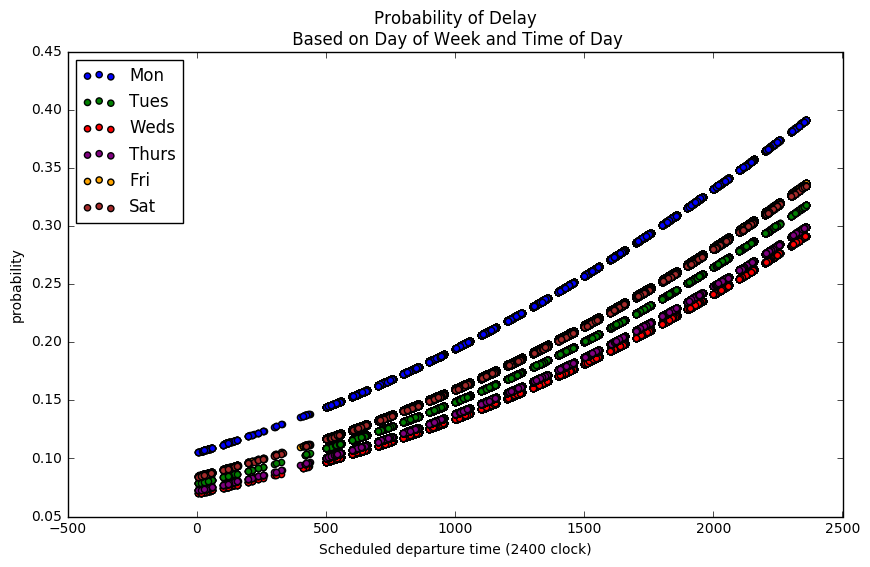

In [10]:
days = ['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
names = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat'] 
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for e, c in enumerate(colors):
    df[df[days[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', label = names[e], color = c, ax=ax)

ax.legend(loc='upper left')
ax.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
ax.set_xlabel('Scheduled departure time (2400 clock)')

This kind of figure showing how probability changes with features really makes things clear for the stakeholder.
Sometimes it's hard to graph it like this but always try this kind of figure to make things clear. It also helps
you! But here we discuss communicating your model to others.

In [11]:
# Build a slightly different model

features = ['CRS_DEP_TIME', 'DAY_OF_WEEK', "DAY_OF_MONTH" ]

X = df[features]
y = df['DEP_DEL15']
#this is a binary column: was the flight delayed or not?

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X)

cm = confusion_matrix(y, predictions)
cm

array([[366501,    832],
       [ 90555,    423]])

In [13]:
# This is a slightly different version of the confusion matrix code we saw before, try playing around
# and getting it the way you think looks best - for example what about changing it to show percentages?

import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):  
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)   
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)      
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

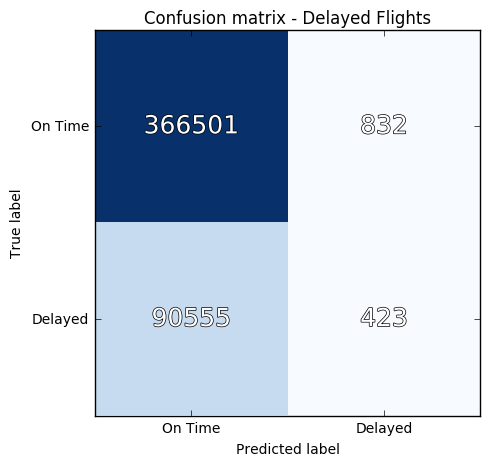

In [14]:
plot_confusion_matrix(cm, title='Confusion matrix - Delayed Flights', labels=['On Time','Delayed'], cmap=plt.cm.Blues)

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve


def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):    
    fpr, tpr, thresholds = roc    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')
    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title)
    plt.legend(loc='best')

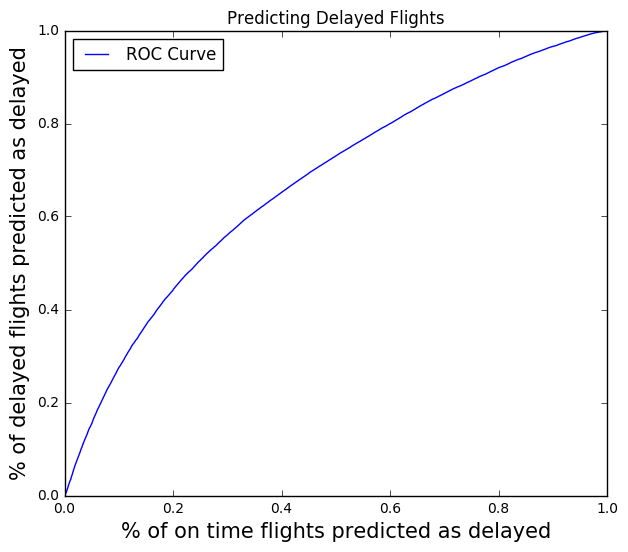

In [16]:
roc=roc_curve(y, model.predict_proba(X)[:,1])
getROCcurve(roc, title='Predicting Delayed Flights', ylabel='% of delayed flights predicted as delayed',\
            xlabel='% of on time flights predicted as delayed')

ROC curves are pretty clear to see and tend to show classification in a favourable way.